In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [13]:
train_data=pd.read_csv("./data/train.csv")
test_data=pd.read_csv("./data/test.csv")

# Data one hot encoding

In [14]:
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = ["Sex"]
one_hot_encoded = encoder.fit_transform(train_data[categorical_columns])
one_hot_encoded_test = encoder.transform(test_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))
one_hot_df_test = pd.DataFrame(one_hot_encoded_test, 
                          columns=encoder.get_feature_names_out(categorical_columns))
train_data = pd.concat([train_data.drop(categorical_columns, axis=1), one_hot_df], axis=1)
test_data = pd.concat([test_data.drop(categorical_columns, axis=1), one_hot_df_test], axis=1)
train_data['BMI'] = train_data['Weight'] / ((train_data['Height'] / 100) ** 2)
test_data['BMI'] = test_data['Weight'] / ((test_data['Height'] / 100) ** 2)

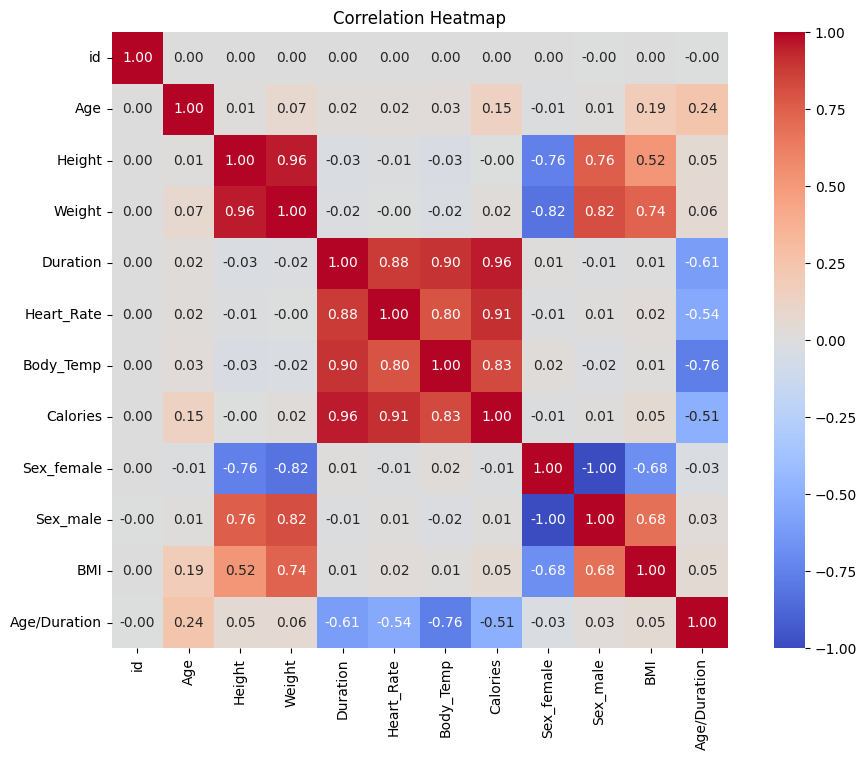

In [60]:
def correlation_heatmap(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap")
    plt.show()

correlation_heatmap(train_data)

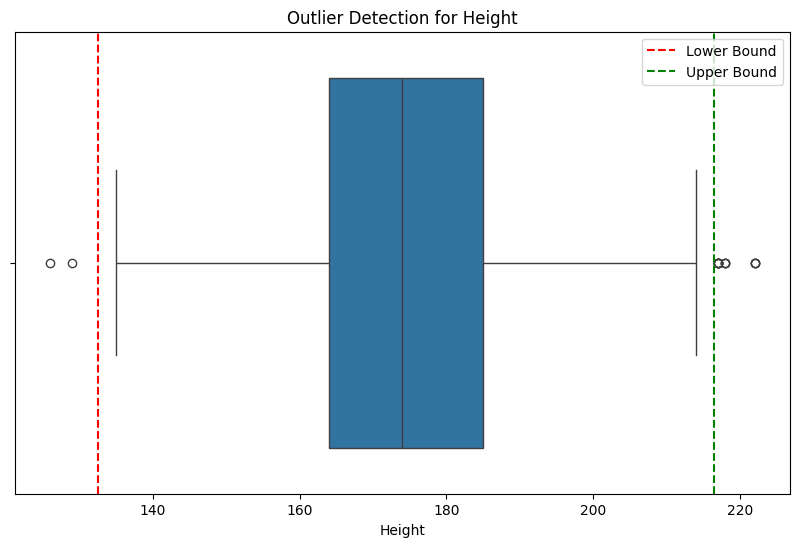

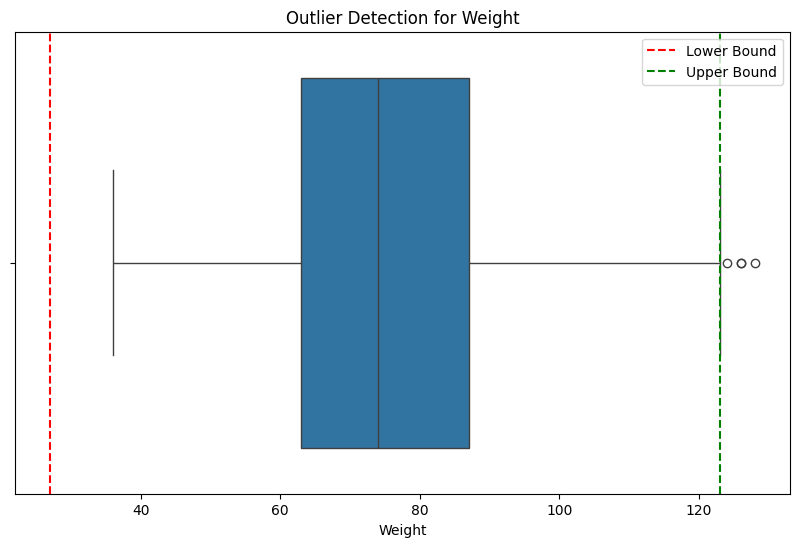

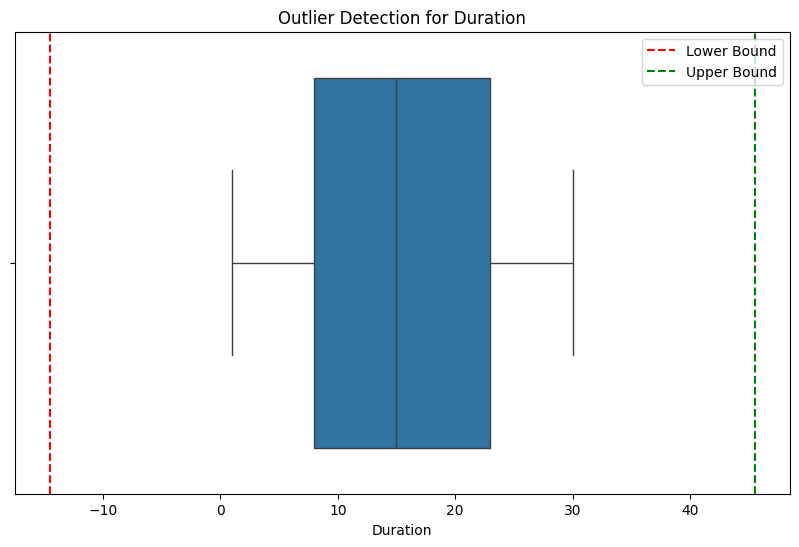

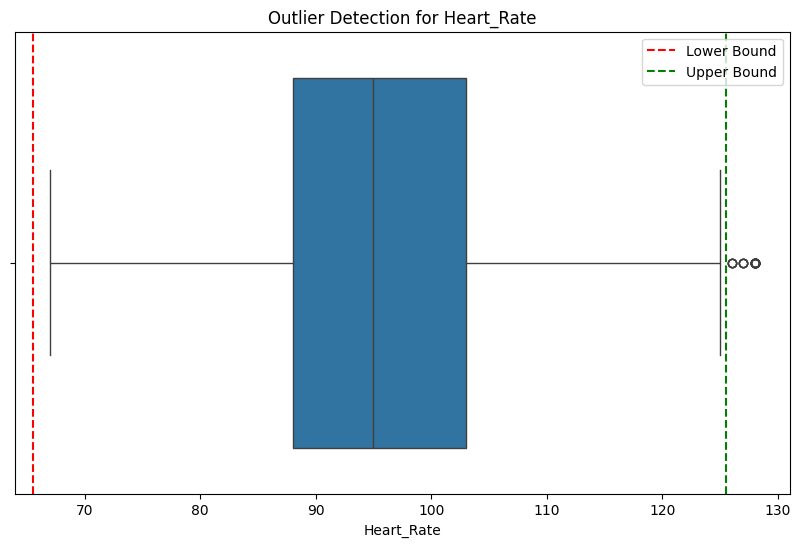

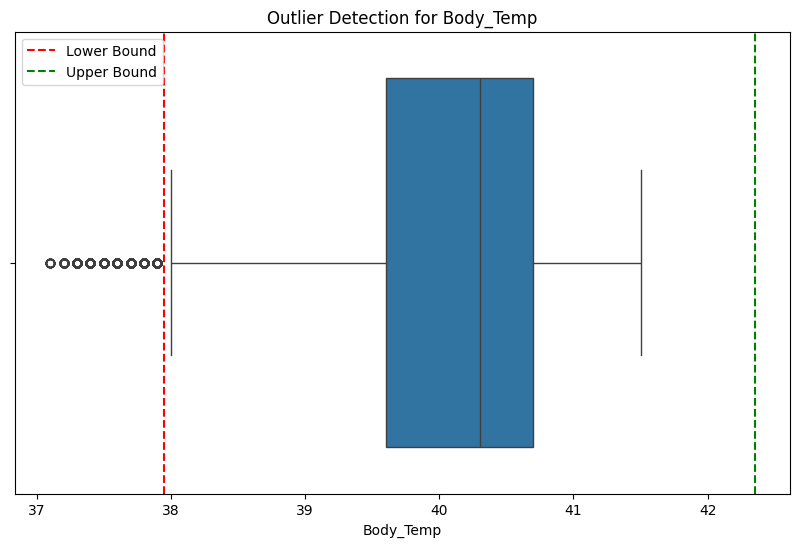

In [253]:
def outlier_detection(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def plot_outliers(data, column):
    lower_bound, upper_bound = outlier_detection(data, column)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    plt.title(f"Outlier Detection for {column}")
    plt.legend()
    plt.show()



def remove_outliers(data, column):
    lower_bound, upper_bound = outlier_detection(data, column)
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

features = ['Height', 'Weight','Duration','Heart_Rate','Body_Temp']
for feature in features:
    plot_outliers(train_data, feature)
    train_data = remove_outliers(train_data, feature)

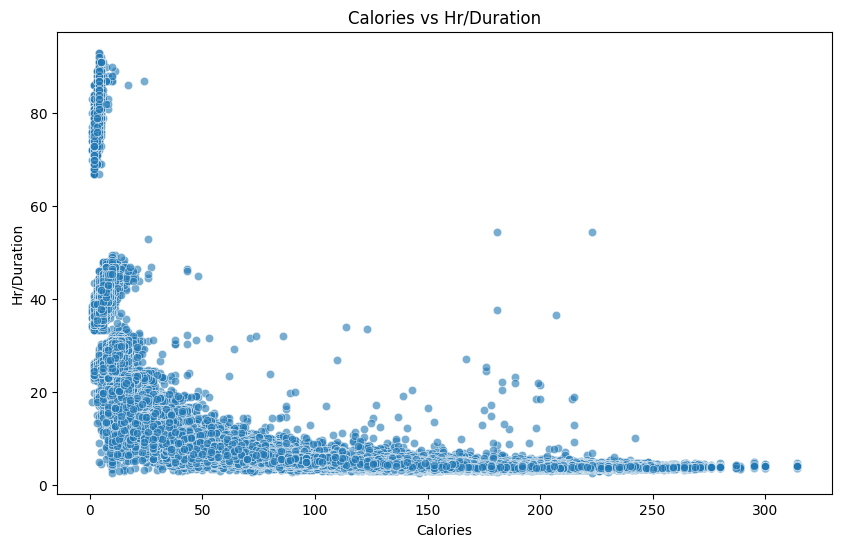

In [269]:
train_data['Hr/Duration'] = train_data['Heart_Rate'] / train_data['Duration']
test_data['Hr/Duration'] = test_data['Heart_Rate'] / test_data['Duration']
def plot_feature_regarding_target(data, feature, target,color_feature):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=data,
        x=feature,
        y=target,
        #hue=color_feature,  
        #palette='viridis',  
        alpha=0.6
    )

    plt.title(f"{feature} vs {target}")
    plt.show()

plot_feature_regarding_target(train_data, "Calories", "Hr/Duration","Age")

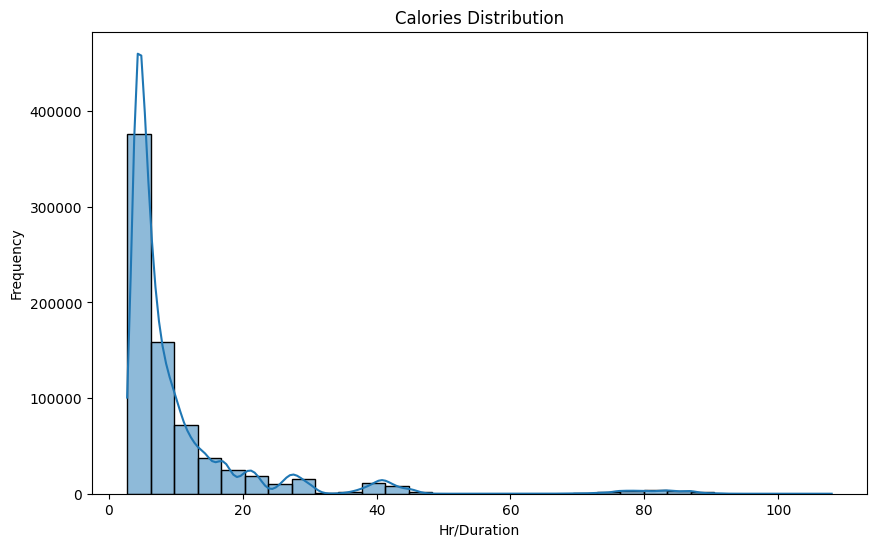

In [211]:
def plot_distribution(data,feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title("Calories Distribution")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

#plot_distribution(train_data,"Hr/Duration")
plot_distribution(train_data,"Hr/Duration")

In [15]:
most_correlated_calories = train_data.corr()["Calories"].sort_values(ascending=False)
most_correlated_calories = most_correlated_calories[most_correlated_calories < 1]
print(most_correlated_calories)
'''
train_data_proc=train_data.drop(columns=['Weight', 'Sex_male',
       'id', 'Height', 'Sex_female'], inplace=False)
test_data_proc=test_data.drop(columns=['Weight', 'Sex_male','Sex_female',
       'id', 'Height'], inplace=False)
'''
#train_data_proc=normalize_data(train_data_proc)
#test_data_proc=normalize_data(test_data_proc)

train_data_proc=train_data.drop(columns=['id'])
test_data_proc=test_data.drop(columns=['id'])


Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
BMI           0.049226
Weight        0.015863
Sex_male      0.012011
id            0.001148
Height       -0.004026
Sex_female   -0.012011
Name: Calories, dtype: float64


In [18]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.neural_network import MLPRegressor

In [19]:
print(train_data_proc.columns)

Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories', 'Sex_female', 'Sex_male', 'BMI'],
      dtype='object')


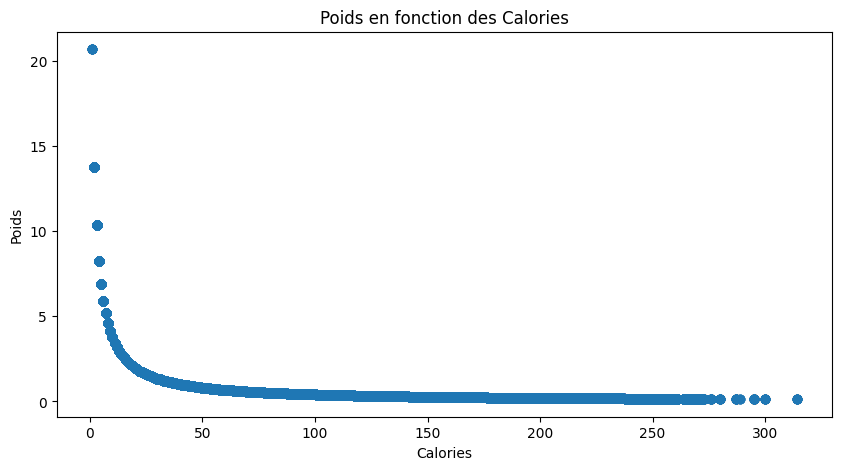

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Créer une copie de travail
target_df = pd.DataFrame()
target_df["Calories"] = train_data["Calories"].copy()
target_df["log_calories"] = np.log1p(target_df["Calories"])

# 2. Binner la target (optionnel ici, juste pour visualiser)
target_df["bin"] = pd.qcut(target_df["Calories"], q=10)

# 3. Créer un poids inversement proportionnel à Calories
# On ajoute +1 pour éviter division par zéro
target_df["weight"] = 1 / (target_df["Calories"] + 1)

# 4. (Optionnel) Normaliser les poids pour éviter qu’ils explosent
target_df["weight"] = target_df["weight"] / target_df["weight"].mean()

# 5. Visualiser la relation Calories ↔ weight
plt.figure(figsize=(10, 5))
plt.scatter(target_df["Calories"], target_df["weight"], alpha=0.4)
plt.title("Poids en fonction des Calories")
plt.xlabel("Calories")
plt.ylabel("Poids")
plt.show()

In [8]:
#train_data_proc=train_data_proc.drop(columns=['Calories'], inplace=False)
x_train, x_val, y_train, y_val = train_test_split(train_data_proc, train_data["Calories"], test_size=0.2, random_state=42)

y_train_log = y_train.apply(lambda x: 0 if x == 0 else np.log(1+x))
y_val_log = y_val.apply(lambda x: 0 if x == 0 else np.log(1+x))

In [9]:
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric="rmsle",
    early_stopping_rounds=10,
    random_state=42
)
model.fit(x_train, y_train_log,
          eval_set=[(x_val, y_val_log)], verbose=True)

[0]	validation_0-rmsle:0.19803
[1]	validation_0-rmsle:0.18204
[2]	validation_0-rmsle:0.16747
[3]	validation_0-rmsle:0.15415
[4]	validation_0-rmsle:0.14390
[5]	validation_0-rmsle:0.13241
[6]	validation_0-rmsle:0.12247
[7]	validation_0-rmsle:0.11290
[8]	validation_0-rmsle:0.10425
[9]	validation_0-rmsle:0.09650
[10]	validation_0-rmsle:0.08936
[11]	validation_0-rmsle:0.08297
[12]	validation_0-rmsle:0.07708
[13]	validation_0-rmsle:0.07192
[14]	validation_0-rmsle:0.06737
[15]	validation_0-rmsle:0.06316
[16]	validation_0-rmsle:0.05929
[17]	validation_0-rmsle:0.05592
[18]	validation_0-rmsle:0.05273
[19]	validation_0-rmsle:0.04996
[20]	validation_0-rmsle:0.04738
[21]	validation_0-rmsle:0.04496
[22]	validation_0-rmsle:0.04283
[23]	validation_0-rmsle:0.04110
[24]	validation_0-rmsle:0.03940
[25]	validation_0-rmsle:0.03764
[26]	validation_0-rmsle:0.03628
[27]	validation_0-rmsle:0.03492
[28]	validation_0-rmsle:0.03357
[29]	validation_0-rmsle:0.03238
[30]	validation_0-rmsle:0.03138
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [266]:
model.score(x_val, y_val_log)

0.995528639857877

In [24]:
y_pred = model.predict(x_val)
print(len([pred for pred in y_pred if pred < 0]))
rmsel = mean_squared_log_error(y_val_log, y_pred)
print(f"RMSLE: {rmsel:.4f}")

0
RMSLE: 0.0003


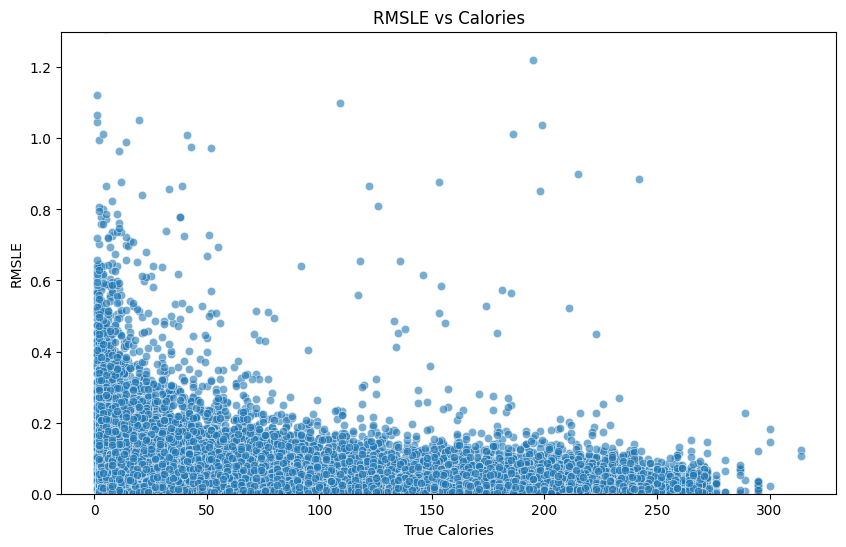

In [23]:
def plot_scatter_rmsle(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    rmsle = np.sqrt(np.square(np.log1p(y_pred) - np.log1p(y_true)))

    data = pd.DataFrame({
        'Calories': y_true,
        'Predicted': y_pred,
        'RMSLE': rmsle
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x="Calories", y="RMSLE", alpha=0.6)
    plt.title("RMSLE vs Calories")
    plt.xlabel("True Calories")
    plt.ylabel("RMSLE")
    plt.ylim((0,1.3))
    plt.show()

    return data
y_val = np.exp(y_val_log)-1
y_pred = np.exp(y_pred)-1
df=plot_scatter_rmsle(y_val, y_pred)
df["bin"] = pd.qcut(df["Calories"], q=10)

In [ ]:
print(df["bin"].value_counts())

bin
(0.999, 14.0]     15877
(42.0, 59.0]      15286
(77.0, 99.0]      15149
(121.0, 149.0]    15086
(149.0, 180.0]    14954
(180.0, 314.0]    14900
(27.0, 42.0]      14811
(14.0, 27.0]      14791
(59.0, 77.0]      14707
(99.0, 121.0]     14439
Name: count, dtype: int64


In [31]:
print(test_data_proc.columns)

Index(['Age', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object')


In [122]:
print(len([pred for pred in y_pred if pred < 0]))

0


In [272]:
y_pred = model.predict(test_data_proc)
y_pred = np.exp(y_pred)-1
print(len([pred for pred in y_pred if pred < 0]))


0


In [273]:
submission = pd.DataFrame({"id": test_data["id"], "Calories": y_pred})
submission.to_csv("submission_7.csv", index=False)